## Installing & Importing libraries

In [ ]:
# Jupyter Environment

# !pip install -U ydata-profiling
# !pip install numpy
# !pip install pandas
# !pip install scipy
# !pip install matplotlib
# !pip install miceforest
# !pip install catboost
# !pip install wheel
# !pip install xgboost
# !pip install optuna
# !pip install tabulate
# !pip install openpyxl

In [ ]:
# VS Code Environment

# %pip install -U ydata-profiling
# %pip install numpy
# %pip install pandas
# %pip install scipy
# %pip install matplotlib
# %pip install miceforest
# %pip install catboost
# %pip install wheel
# %pip install xgboost
# %pip install optuna
# %pip install tabulate
# %pip install openpyxl

**WARNING!** <br>

Code was prepared in Python 3.11.1, therefore some functions may not work as expected or cause error in older versions.

In [1]:
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import miceforest as mf
import numpy as np
import pandas as pd
from openpyxl import load_workbook
import optuna
import pickle
import random
import scipy as sc
from scipy.stats import chi2_contingency, describe
import seaborn as sns
import re
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, PowerTransformer
from tabulate import tabulate
import unicodedata
import xgboost as xgb
from ydata_profiling import ProfileReport

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
pd.options.display.float_format = '{:,.3f}'.format

## Data preprocessing

### Handling faulty data and name shortening

In [3]:
df, pred_df = [
    pd.read_excel('Data/data.xlsx', na_values=['BD', np.nan], sheet_name=i)
    for i in [0, 1]
]

pred_df.rename(
    columns={'WYNAGRODZENIE PODSTAWOWE (PROGNOZY)': 'WYNAGRODZENIE'},
    inplace=True)

df.rename(columns={'WYNAGRODZENIE PODSTAWOWE': 'WYNAGRODZENIE'}, inplace=True)

pred_df['WYNAGRODZENIE'] = np.nan

dataset = pd.concat([df, pred_df])

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581 entries, 0 to 119
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   WYNAGRODZENIE                                461 non-null    float64
 1   Funkcja                                      581 non-null    object 
 2   OBCOKRAJOWIEC                                581 non-null    object 
 3   PŁEĆ                                         581 non-null    object 
 4   MAKROSEKTOR                                  581 non-null    object 
 5   WIG                                          581 non-null    object 
 6   Skarb Państwa                                581 non-null    object 
 7   Spółka rodzinna                              581 non-null    object 
 8   ZATRUDNIENIE
2021 (Etaty)                    554 non-null    float64
 9   KOMITET DS. WYNAGRODZEŃ W RADZIE NADZORCZEJ  495 non-null    object 
 10  RO

For a practical approach, column names have been simplified, spaces have been replaced with underscores , and uppercase letters have been converted to lowercase. In addition, the brackets have been removed along with the content, although this is some loss of information, it should not significantly affect the analysis. Only the column *Komitet ds. wynagrodzeń w radzie nadzorczej*  (here in after **KDWWRN**) has been assigned an acronym due to its long name.

In [4]:
def gracefully_degrade_to_ascii(text: str):
    return unicodedata.normalize('NFKD', text).encode('ascii',
                                                      'ignore').decode('ascii')


def change_cols_name(text: str):

    text = text.strip().lower().replace(
        'ł',
        'l')  # normalization followed by ascii encoding deletes 'ł' letter

    text = gracefully_degrade_to_ascii(text)

    text = re.sub(r'\s*[0-9]*\s+\(.*\)', '', text)

    text = text.replace(' ', '_')

    if (len(text.split('_')) > 2):

        return "".join([x.upper()[0] for x in text.split('_')])

    else:

        return text

dataset.columns = [change_cols_name(col) for col in dataset.columns]

dataset.head()

wynagrodzenie          funkcja obcokrajowiec plec         makrosektor  \
0     60,000.000  członek zarządu           NIE    M    Handel i Usługi    
1  3,387,978.980   prezes zarządu           NIE    M             Finanse   
2    292,368.280   prezes zarządu           NIE    M  Dobra Konsumpcyjne   
3    100,533.000  członek zarządu           NIE    K    Handel i Usługi    
4    733,188.000  członek zarządu           NIE    K  Dobra Konsumpcyjne   

       wig skarb_panstwa spolka_rodzinna  zatrudnienie KDWWRN   roe   roa  \
0     Inny           NIE             TAK     1,335.000   NIE  0.126 0.046   
1     Inny           NIE             TAK        44.000    NIE 0.008 0.004   
2     Inny           NIE             TAK        81.000   NIE  0.049 0.030   
3  mWIG 40           NIE             NIE       235.000    TAK 0.402 0.272   
4     Inny           NIE             NIE     1,791.000    TAK 1.975 0.158   

   zysk_netto  wartosc_rynkowa    eps  
0       25737          202.090  3.400  
1        3489           86.270  0.094  
2        3330           30.650  1.233  
3      141265        2,548.320 19.347  
4      406580        5,197.300 39.584

By initially exploring the categorical data by checking their unique values it was noticed that the KDWWRN variable had three unique values (not counting the blank), but this was only due to the extra space next to the value 'NIE '. The extra space was removed to make the variable binary logically.

In [5]:
categorical_vars = dataset.select_dtypes(exclude=np.number).columns

for col in categorical_vars:
    print(f'{col}, values: {dataset[col].unique()}', end='\n\n')

funkcja, values: ['członek zarządu' 'prezes zarządu' 'wiceprezes zarządu']

obcokrajowiec, values: ['NIE' 'TAK']

plec, values: ['M' 'K']

makrosektor, values: ['Handel i Usługi ' 'Finanse' 'Dobra Konsumpcyjne'
 'Produkcja Przemysłowa i Budowlano-Montażowa']

wig, values: ['Inny' 'mWIG 40' 'sWIG 80' 'WIG 20']

skarb_panstwa, values: ['NIE' 'TAK']

spolka_rodzinna, values: ['TAK' 'NIE']

KDWWRN, values: ['NIE ' 'NIE' 'TAK' nan]



In [6]:
def name_mapper(text: str):

    text = text.strip()

    return "".join(x[0] for x in text.upper().split(' '))


dataset.replace({'NIE ': 'NIE'}, inplace=True)

for col in ['makrosektor', 'funkcja']:

    dataset[col] = dataset[col].apply(name_mapper)

    print(f'{col:15} {dataset[col].unique()}')

makrosektor     ['HIU' 'F' 'DK' 'PPIB']
funkcja         ['CZ' 'PZ' 'WZ']


__Re-division of data into a learning set and a prediction set__

It was a priori known that the learning set has no missing data in the column with the explanatory variable, so a secondary split can easily be made by suggesting the presence of the variable __WYNAGRODZENIE PODSTAWOWE__.

In [7]:
df = dataset[~pd.isna(dataset['wynagrodzenie'])]

pred_df = dataset[pd.isna(dataset['wynagrodzenie'])]

print(len(df))

print(len(pred_df))

461
120


When it came to numeric variables, one line seemed to be wrong. The value **ROA** had a different sign than net profit, and knowing that **ROA** is the _quotient of net profit and total assets_, this would indicate that total assets have a negative value, and such a situation cannot be the case. It was therefore decided to delete the row with these values.

In [8]:
faulty_index = df[
    np.sign(df['zysk_netto']) != np.sign(df['roa'])].index.to_list()

print(
    f'{len(faulty_index)} observation(s) ({len(faulty_index) / len(df)*100:.2f}% of data)'
)

df.loc[faulty_index, ['zysk_netto', 'roa']]

1 observation(s) (0.22% of data)


zysk_netto   roa
146        -482 0.003

In [9]:
df.drop(index=faulty_index, inplace=True)

C:\Users\trako\AppData\Local\Temp\ipykernel_4480\510601924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=faulty_index, inplace=True)


### Creating a report and diving into alerts

In [10]:
report1 = ProfileReport(df, title="Report1")
report1

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Some of the relevant alerts:

- **ZATRUDNIENIE** has 6 (1.3%) zeros
- **KDWRN** has 70 (15.2%) missing values
- **ZATRUDNIENIE** has 27 (5.9%) missing values
- **OBCOKRAJOWIEC** is highly imbalanced (66.1%)
- **Skarb Państwa** is highly imbalanced (78.3%)
- A lot of high correlations with both categorical and numerical data

Below all of the __high correlation__ alerts were written:

- __WYNAGRODZENIE__ is highly correlated with __Zatrudnienie__
- __Zatrudnienie__ is highly correlated with __WYNAGRODZENIE__, __wartość rynkowa__, *__WIG__*, __*Skarb Państwa*__ and *__KDWWRN__*
- __ROE__ is highly correlated with __ROA__, __Zysk netto__ and __EPS__
- __ROA__ - same as __ROE__
- __Zysk netto__ is highly correlated with __ROE__, __ROA__ (obviously), __wartość rynkowa__, __EPS__, *__WIG__*, *__Skarb Państwa__*
- __Wartość rynkowa__ is highly correlated with __Zatrudnienie__, __Zysk netto__, *__WIG__*, __*Skarb państwa*__
- __EPS__ is highly correlated with __ROE__, __ROA__, and __Zysk netto__
- *__WIG__* is highly correlated with __Zatrudnienie__, __Zysk netto__, __wartość rynkowa__, *__KDWWRN__*
- __*Skarb Państwa*__ is highly correlated with __Zatrudnienie__, __Zysk netto__, __wartość rynkowa__
- *__KDWWRN__* is highly correlated with __Zatrudnienie__ and *__WIG__*

Categorical variables are in bold and italics whereas numerical variables are only in bold.<br>
Exogenous variable is written in CAPITAL LETTERS (excluding variables written in acronyms).

One qualitative variable is missing some data (__Zatrudnienie__). Zatrudnienie is highly correlated with 5 variables (categorical ones are in italics):

- Wartość rynkowa (68,1%)
- _Skarb państwa_ (60,6%)
- _WIG_ (53,6%)
- Wynagrodzenie (52,4%)
- _KDWRN_ (43,8%)

### Analysis of distribution of variables

One form of verification of the distribution of variables is the histogram. Intuitively, one may
assume that the variables do not have a normal distribution especially in terms of skewness. Numerous economists have shown an interest in skewed distributions because many economic variables (classically, income) are skewed. For each of the numerical variables, including the explanatory variable, a histogram was created. 

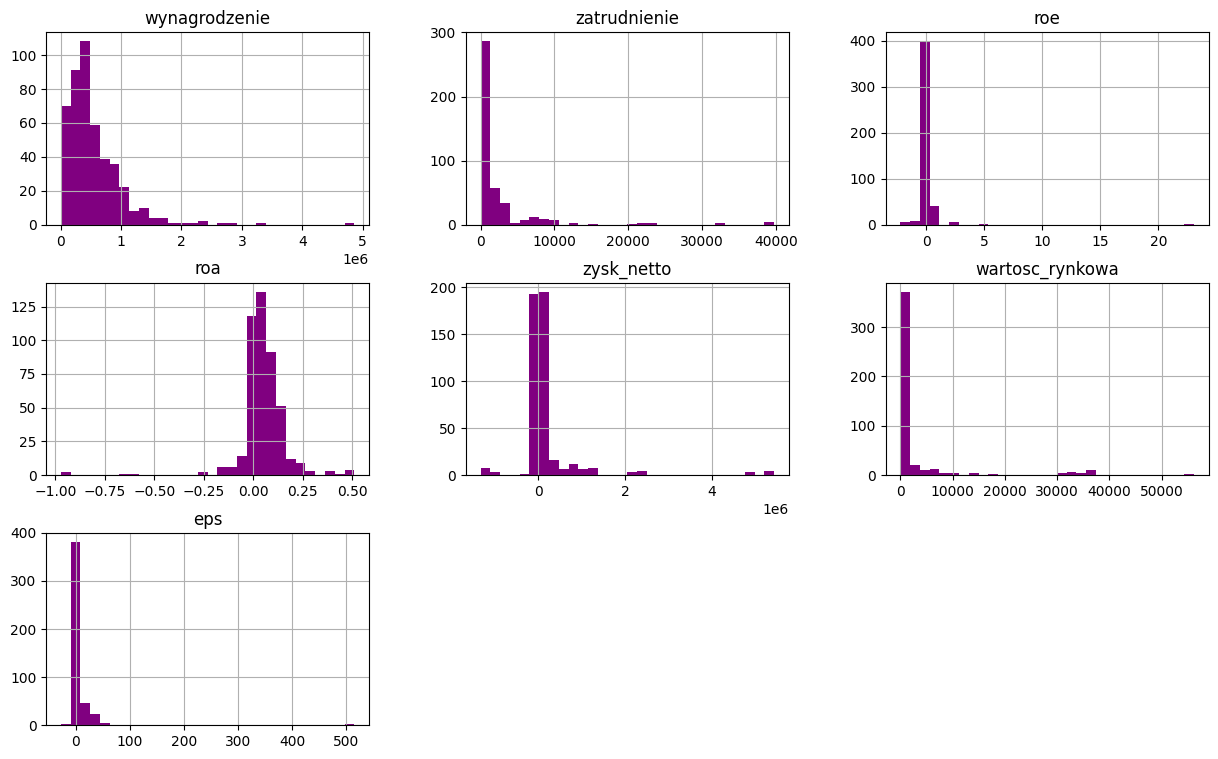

In [11]:
df.hist(bins=30, figsize=(15, 9), color='purple')
plt.show()

To verify the presence of skewness (deviation from normal distribution) D'Agostino skewness test was used. The test should decide whether the null hypothesis of normality should be accepted or rejected at the chosen level of significance. If null hypothesis of normality is true, a negative (positive) skewness generates on average negative (positive) values. <br>By analysing the graphs, it is possible to hypothesise that the skewness of the distributions deviates from the skewness of the normal distribution and are therefore asymmetric. In addition to the skewness tests themselves, it was decided to calculate the asymmetry coefficient, which further illustrates how far the distributions deviate from symmetry. 

In [12]:
for col in df.select_dtypes(np.number).columns:

    print(f'Column: "{col}"')
    print(f'skew value: {sc.stats.skew(df.dropna()[col]):.2f}')
    print(
        f"skew test's (two-sided) p-value: {sc.stats.skewtest(df.dropna()[col]).pvalue:.2g}"
    )
    print()

Column: "wynagrodzenie"
skew value: 3.30
skew test's (two-sided) p-value: 5.5e-45

Column: "zatrudnienie"
skew value: 4.25
skew test's (two-sided) p-value: 5.5e-56

Column: "roe"
skew value: 12.30
skew test's (two-sided) p-value: 3.9e-116

Column: "roa"
skew value: -2.84
skew test's (two-sided) p-value: 3.7e-39

Column: "zysk_netto"
skew value: 4.55
skew test's (two-sided) p-value: 3.9e-59

Column: "wartosc_rynkowa"
skew value: 3.25
skew test's (two-sided) p-value: 2.2e-44

Column: "eps"
skew value: 10.31
skew test's (two-sided) p-value: 1.5e-104



In [13]:
pt = PowerTransformer().set_output(transform="pandas")

df_pt_transformed = pt.fit_transform(df.dropna().select_dtypes(np.number))

for col in df_pt_transformed.columns:

    print(f'Column: "{col} (transformed)"')
    print(f'skew value: {sc.stats.skew(df_pt_transformed[col]):.2f}')
    print(
        f"skew test's (two-sided) p-value: {sc.stats.skewtest(df_pt_transformed[col]).pvalue:.2g}"
    )
    print()

Column: "wynagrodzenie (transformed)"
skew value: 0.03
skew test's (two-sided) p-value: 0.79

Column: "zatrudnienie (transformed)"
skew value: -0.00
skew test's (two-sided) p-value: 0.97

Column: "roe (transformed)"
skew value: -1.58
skew test's (two-sided) p-value: 3.9e-21

Column: "roa (transformed)"
skew value: 0.54
skew test's (two-sided) p-value: 4.2e-05

Column: "zysk_netto (transformed)"
skew value: 2.29
skew test's (two-sided) p-value: 1.2e-31

Column: "wartosc_rynkowa (transformed)"
skew value: 0.04
skew test's (two-sided) p-value: 0.77

Column: "eps (transformed)"
skew value: -0.61
skew test's (two-sided) p-value: 5.6e-06



Although some of the transformed data still show asymmetry, the skewness coefficients have improved in each case (i.e. the values are less different from zero). This transformation can therefore be useful for some models and the search for descriptive values, as the original data may simply result in the removal of rows where the company generates large net profit and so on.

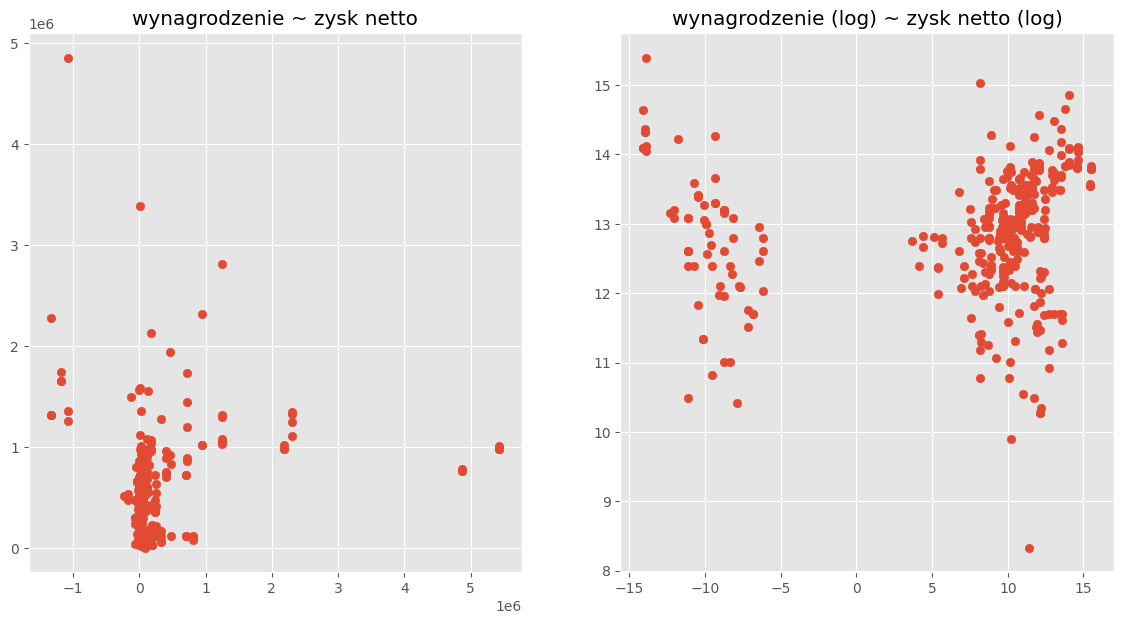

In [14]:
def logarithmize(x):

    if x != 0:
        if x > 0:
            return np.log(x + 1)
        else:
            return -np.log(-x + 1)
    return x


with plt.style.context('ggplot'):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

    axes[0].scatter(x='zysk_netto', y='wynagrodzenie', data=df.dropna())
    axes[0].set_title('wynagrodzenie ~ zysk netto')
    axes[1].scatter(x=df.dropna()['zysk_netto'].apply(logarithmize),
                    y=df.dropna()['wynagrodzenie'].apply(logarithmize))
    axes[1].set_title('wynagrodzenie (log) ~ zysk netto (log)')

plt.show()

It would appear that the greater relevance to the salary of individuals on the board is the size of the company itself that can be measured by the size of the outcome, i.e. the absolute value of net profit. In order to better illustrate the sensitivity of the hypothesis, a scatter plot was made, both for the original. The relationship is much more apparent for transformed data. It can be seen that the majority of companies showed a positive financial result. To verify the hypothesis on the insignificance of the sign of the financial result, the chi-square contingency test was used.

In [15]:
pd.qcut(df['wynagrodzenie'], 4).value_counts()

(440560.5, 720000.0]     120
(4155.999, 239595.0]     115
(239595.0, 440560.5]     115
(720000.0, 4860000.0]    110
Name: wynagrodzenie, dtype: int64

In [16]:
df['zysk_netto'].apply(lambda x: 0
                       if x < 0 else 1).value_counts()  # 1 - profit, 0 - loss

1    382
0     78
Name: zysk_netto, dtype: int64

In [17]:
crosstab = pd.crosstab(df['zysk_netto'].apply(lambda x: 0 if x < 0 else 1),
                       pd.qcut(df['wynagrodzenie'], 4),
                       margins=False)

stat, pvalue, deg_f, expected = chi2_contingency(crosstab)
print('Test statistic:', stat)
print('df:', deg_f)
print('P-value:', pvalue)
print('Expected values:', expected)

Test statistic: 3.1402933889844884
df: 3
P-value: 0.37049639084200464
Expected values: [[19.5        19.5        20.34782609 18.65217391]
 [95.5        95.5        99.65217391 91.34782609]]


The chi-square contingency test showed that the sign of the financial result (plus or minus) does not affect salary, so we transform net profit with the absolute value.

In [18]:
df.loc[:, 'zysk_netto'] = df.loc[:, 'zysk_netto'].apply(abs)
pred_df.loc[:, 'zysk_netto'] = pred_df.loc[:, 'zysk_netto'].apply(abs)

C:\Users\trako\AppData\Local\Temp\ipykernel_4480\1826985363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'zysk_netto'] = df.loc[:, 'zysk_netto'].apply(abs)
C:\Users\trako\AppData\Local\Temp\ipykernel_4480\1826985363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df.loc[:, 'zysk_netto'] = pred_df.loc[:, 'zysk_netto'].apply(abs)


### Encoding qualitative variables

In [19]:
dataset = pd.concat([df, pred_df])

In analysing socio-economic data, a key step is to code categorical variables. For this purpose, the *One Hot Encoding* technique was used, which transforms categorical variables into a binary representation; each category is encoded as a vector of zeros and a single one, indicating the category membership of the category

In [20]:
nominal_vars = [
    var for var in categorical_vars if var not in ['KDWWRN', 'wig', 'funkcja']
]  # get_dummies method would code nan values separately - we will keep it as nan for oncoming imputation

nominal_vars

['obcokrajowiec', 'plec', 'makrosektor', 'skarb_panstwa', 'spolka_rodzinna']

In [21]:
dataset = pd.get_dummies(
    dataset, columns=nominal_vars, drop_first=True
)  # the first one is the reference variable; this is what is required in an economic model
dataset.head()

wynagrodzenie funkcja      wig  zatrudnienie KDWWRN   roe   roa  \
0     60,000.000      CZ     Inny     1,335.000    NIE 0.126 0.046   
1  3,387,978.980      PZ     Inny        44.000    NIE 0.008 0.004   
2    292,368.280      PZ     Inny        81.000    NIE 0.049 0.030   
3    100,533.000      CZ  mWIG 40       235.000    TAK 0.402 0.272   
4    733,188.000      CZ     Inny     1,791.000    TAK 1.975 0.158   

   zysk_netto  wartosc_rynkowa    eps  obcokrajowiec_TAK  plec_M  \
0       25737          202.090  3.400                  0       1   
1        3489           86.270  0.094                  0       1   
2        3330           30.650  1.233                  0       1   
3      141265        2,548.320 19.347                  0       0   
4      406580        5,197.300 39.584                  0       0   

   makrosektor_F  makrosektor_HIU  makrosektor_PPIB  skarb_panstwa_TAK  \
0              0                1                 0                  0   
1              1                0                 0                  0   
2              0                0                 0                  0   
3              0                1                 0                  0   
4              0                0                 0                  0   

   spolka_rodzinna_TAK  
0                    1  
1                    1  
2                    1  
3                    0  
4                    0

For the variables *funkcja* and *wig*, where there is a hierarchy of values,
*ordinal encoding* has been used. This means that the lowest value corresponds to the 'lowest'
function or not belonging to *sWIG 80*, *mWIG40* or *WIG20*, based on the fact that these indices follow the ranking of listed companies, it was considered that the value 'Inny' means an even lower position in the companies ranking ont the stock market.

In [22]:
ord_mapper = {
    'funkcja': {
        'CZ': 1,
        'WZ': 2,
        'PZ': 3
    },
    'wig': {
        'Inny': 1,
        'sWIG 80': 2,
        'mWIG 40': 3,
        'WIG 20': 4
    }
}

for col in ord_mapper.keys():

    dataset[col] = dataset[col].map(ord_mapper[col])

dataset.head()

wynagrodzenie  funkcja  wig  zatrudnienie KDWWRN   roe   roa  zysk_netto  \
0     60,000.000        1    1     1,335.000    NIE 0.126 0.046       25737   
1  3,387,978.980        3    1        44.000    NIE 0.008 0.004        3489   
2    292,368.280        3    1        81.000    NIE 0.049 0.030        3330   
3    100,533.000        1    3       235.000    TAK 0.402 0.272      141265   
4    733,188.000        1    1     1,791.000    TAK 1.975 0.158      406580   

   wartosc_rynkowa    eps  obcokrajowiec_TAK  plec_M  makrosektor_F  \
0          202.090  3.400                  0       1              0   
1           86.270  0.094                  0       1              1   
2           30.650  1.233                  0       1              0   
3        2,548.320 19.347                  0       0              0   
4        5,197.300 39.584                  0       0              0   

   makrosektor_HIU  makrosektor_PPIB  skarb_panstwa_TAK  spolka_rodzinna_TAK  
0                1                 0                  0                    1  
1                0                 0                  0                    1  
2                0                 0                  0                    1  
3                1                 0                  0                    0  
4                0                 0                  0                    0

In [23]:
dataset['KDWWRN'] = dataset['KDWWRN'].map({'TAK': 1, 'NIE': 0})

dataset['KDWWRN'].unique()

array([ 0.,  1., nan])

In [24]:
df = dataset[~pd.isna(dataset['wynagrodzenie'])]

pred_df = dataset[pd.isna(dataset['wynagrodzenie'])]

### Imputing missing values

**miceforest**: Fast, Memory Efficient Imputation with LightGBM

Fast, memory efficient Multiple Imputation by Chained Equations (MICE) with lightgbm.

miceforest was designed to be:

- __Fast__
  - Uses lightgbm as a backend
  - Has efficient mean matching solutions.
  - Can utilize GPU training
- __Flexible__
  - Can impute pandas dataframes and numpy arrays
  - Handles categorical data automatically
  - Fits into a sklearn pipeline
  - User can customize every aspect of the imputation process
- __Production Ready__
  - Can impute new, unseen datasets quickly
  - Kernels are efficiently compressed during saving and loading
  - Data can be imputed in place to save memory
  - Can build models on non-missing data


__miceforest__ documentation: **[LINK](https://pypi.org/project/miceforest/)**

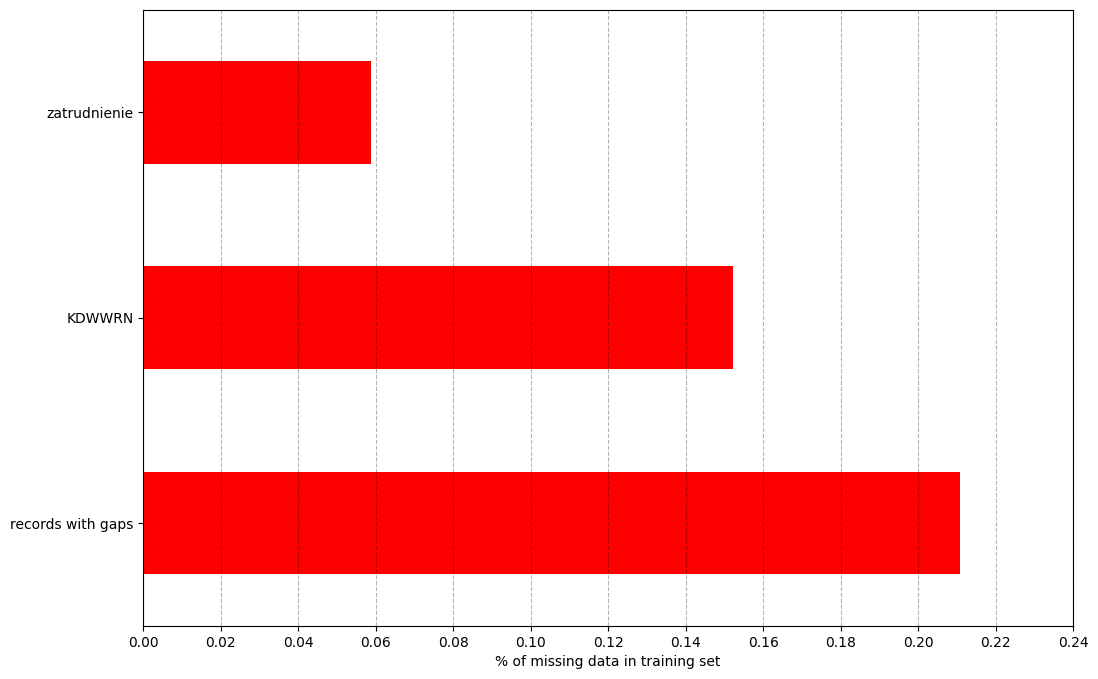

In [25]:
missing = df.isnull().sum() / len(df)

missing = missing[missing > 0]

missing['records with gaps'] = np.count_nonzero(df.isnull()) / len(df)

missing = missing.sort_values(ascending=False)

missing.plot.barh(color='red')

plt.xticks(np.arange(0, 25, 2) / 100)

plt.xlabel('% of missing data in training set')

plt.grid(axis='x', linestyle='--', color='black', alpha=0.3)

In [26]:
numerical_vars = [col for col in df.columns if len(df[col].unique()) > 5]

One of the variables with gaps was the column employment. It contains more than **5%** of missing data, so the idea of deleting the rows was rejected. Two methods were considered:

- imputation by the k nearest neighbours,
- miceForest.

In [27]:
def imput_optimize(dataframe: pd.DataFrame):

    data = pd.DataFrame(columns=['Model', 'RMSE', 'MAE'])

    for _ in range(30):

        X_train, X_test, y_train, y_test = train_test_split(
            dataframe, range(len(dataframe)), test_size=.2)

        y_true = X_test['zatrudnienie']

        sample = X_test.index.to_list()

        for model in ['KNN', 'miceForest']:

            if model == 'KNN':

                pt = PowerTransformer().set_output(transform='pandas')

                df_copy = pt.fit_transform(dataframe.loc[:, numerical_vars])

                df_copy.loc[sample, 'zatrudnienie'] = np.nan

                sc = StandardScaler()

                df_copy.loc[:, :] = sc.fit_transform(df_copy)

                knn_imputer = KNNImputer()

                df_copy.loc[:, :] = knn_imputer.fit_transform(df_copy)

                df_copy.loc[:, :] = sc.inverse_transform(df_copy)

                df_copy.loc[:, :] = pt.inverse_transform(df_copy)

                y_pred = df_copy.loc[sample, 'zatrudnienie']

                data.loc[len(data)] = [
                    model,
                    mean_squared_error(y_true, y_pred, squared=False),
                    mean_absolute_error(y_true, y_pred)
                ]

            else:

                df_copy = dataframe.copy(deep=True)

                df_copy.loc[sample, 'zatrudnienie'] = np.nan

                kds = mf.ImputationKernel(
                    df_copy,
                    save_all_iterations=True,
                )

                kds.mice(iterations=3, n_estimators=50, boosting='gbdt')

                df_copy = kds.complete_data()

                y_pred = df_copy.loc[sample, 'zatrudnienie']

                data.loc[len(data)] = [
                    model,
                    mean_squared_error(y_true, y_pred, squared=False),
                    mean_absolute_error(y_true, y_pred)
                ]

    return data

df_opt = imput_optimize(df.dropna())

df_opt.head(6)

Model      RMSE       MAE
0         KNN 3,017.564 1,071.829
1  miceForest 1,095.509   313.078
2         KNN 1,791.338   858.733
3  miceForest   606.801   280.257
4         KNN 2,358.746   985.650
5  miceForest   730.328   332.464

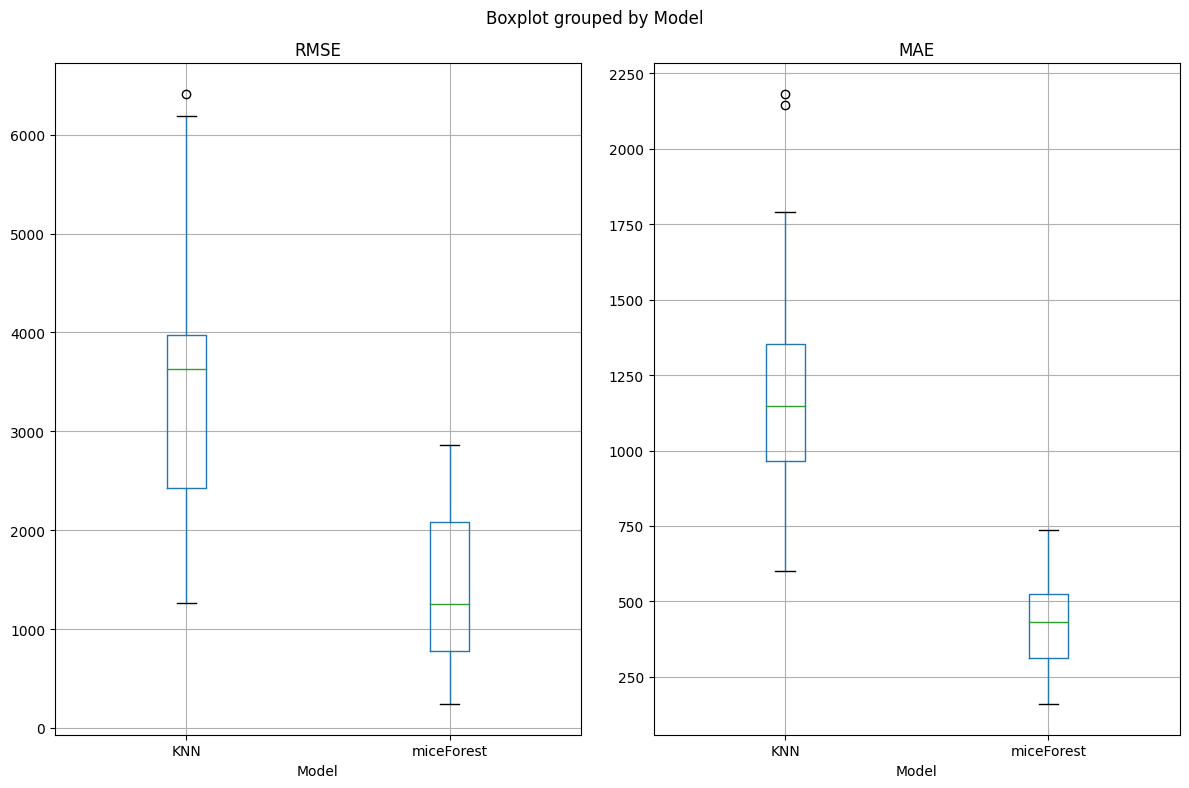

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_opt.boxplot(column='RMSE', by='Model', ax=axes[0])
df_opt.boxplot(column='MAE', by='Model', ax=axes[1])

plt.tight_layout(w_pad=2)
plt.show()

In testing the imputation algorithms, 30 iterations were performed, where in each iteration the calculated **RMSE** and **MAE** errors were calculated. Box plots were created to check the median
results. As can be seen, the miceForest algorithm performs significantly better on both measures, This is why it was chosen for the imputation of the *zatrudnienie* variable. However, 
it is worth noting, that this algorithm (like any other imputation algorithm) imputes any missing variable, and therefore also **KDWWRN**. Due to the fact that missing records also appear in the test set, indices with missing values in **KDWWRN** were stored in the variable and then secondarily assigned a value of **NA**.

In [29]:
dataset = pd.concat([df, pred_df])

for col in [*['KDWWRN', 'funkcja', 'wig'], *dataset.columns[10:].to_list()]:

    dataset.loc[:, col] = dataset.loc[:, col].astype('category')

df = dataset[~pd.isna(dataset['wynagrodzenie'])]

pred_df = dataset[pd.isna(dataset['wynagrodzenie'])]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460 entries, 0 to 460
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   wynagrodzenie        460 non-null    float64 
 1   funkcja              460 non-null    category
 2   wig                  460 non-null    category
 3   zatrudnienie         433 non-null    float64 
 4   KDWWRN               390 non-null    category
 5   roe                  460 non-null    float64 
 6   roa                  460 non-null    float64 
 7   zysk_netto           460 non-null    int64   
 8   wartosc_rynkowa      460 non-null    float64 
 9   eps                  460 non-null    float64 
 10  obcokrajowiec_TAK    460 non-null    category
 11  plec_M               460 non-null    category
 12  makrosektor_F        460 non-null    category
 13  makrosektor_HIU      460 non-null    category
 14  makrosektor_PPIB     460 non-null    category
 15  skarb_panstwa_TAK    46

In [30]:
missing_committee = df[pd.isna(df['KDWWRN'])].index.to_list()

In [31]:
kds_employ = mf.ImputationKernel(
    df,
    save_all_iterations=True,
)

kds_employ.mice(iterations=3, n_estimators=50, boosting='gbdt')

df = kds_employ.complete_data()

df.loc[missing_committee, 'KDWWRN'] = np.nan

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460 entries, 0 to 460
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   wynagrodzenie        460 non-null    float64 
 1   funkcja              460 non-null    category
 2   wig                  460 non-null    category
 3   zatrudnienie         460 non-null    float64 
 4   KDWWRN               390 non-null    category
 5   roe                  460 non-null    float64 
 6   roa                  460 non-null    float64 
 7   zysk_netto           460 non-null    int64   
 8   wartosc_rynkowa      460 non-null    float64 
 9   eps                  460 non-null    float64 
 10  obcokrajowiec_TAK    460 non-null    category
 11  plec_M               460 non-null    category
 12  makrosektor_F        460 non-null    category
 13  makrosektor_HIU      460 non-null    category
 14  makrosektor_PPIB     460 non-null    category
 15  skarb_panstwa_TAK    46

In the case of the variable **KDWWRN** there is a greater problem of missing rows in both the
training set as well as the test set, and there are also many more rows with gaps. Again, it was decided to test the _miceForest_ algorithm.

In [32]:
def knn_optimize_mf(dataframe: pd.DataFrame):

    scores = [precision_score, recall_score, f1_score]

    data = pd.DataFrame(columns=['Boosting', 'Precision', 'Recall', 'F1'])

    for _ in range(40):

        sample = random.sample(dataframe.index.to_list(), k=58)

        y_true = dataframe.loc[sample, 'KDWWRN']

        for boosting in ['standard', 'gbdt']:

            df_copy = dataframe.copy(deep=True)

            df_copy.loc[sample, 'KDWWRN'] = np.nan

            kds = mf.ImputationKernel(
                df_copy,
                save_all_iterations=True,
            )
            if boosting == 'standard':

                kds.mice(iterations=3, n_estimators=50)

            else:

                kds.mice(iterations=3, n_estimators=50, boosting=boosting)

            df_copy = kds.complete_data()

            y_pred = df_copy.loc[sample, 'KDWWRN']

            data.loc[len(data)] = [
                boosting, *[score(y_true, y_pred) for score in scores]
            ]

    return data


df_opt = knn_optimize_mf(df.dropna().iloc[:, 1:])

print(
    tabulate(df_opt.groupby('Boosting', as_index=False).mean(),
             headers='keys',
             tablefmt='fancy_grid',
             showindex=False,
             floatfmt='.4f'))

╒════════════╤═════════════╤══════════╤════════╕
│ Boosting   │   Precision │   Recall │     F1 │
╞════════════╪═════════════╪══════════╪════════╡
│ gbdt       │      0.9731 │   0.9607 │ 0.9657 │
├────────────┼─────────────┼──────────┼────────┤
│ standard   │      0.9744 │   0.9446 │ 0.9578 │
╘════════════╧═════════════╧══════════╧════════╛


In general, an algorithm with both parameter values boosting performs very well, however, the gdbt (gradient boosting decision trees) perform slightly better than standard one (based on RandomForest), which is why it was decided to impute the variables in the training and test set with the miceForest algorithm with this particular parameter.

There are no values in the explanatory variable in the validation set, which will negatively affect the data imputation process in this set as the explanatory variable has no missing data in the learning set

In [33]:
X = df.drop('wynagrodzenie', axis=1)
X_pred = pred_df.drop('wynagrodzenie', axis=1)

In [34]:
for col, d1, d2 in zip(
        X.columns, X.dtypes, X_pred.dtypes
):  #checking if dtypes are the same - necessary for miceForest algorithm

    print(f'{col:20} {str(d1):8} {d2}')

funkcja              category category
wig                  category category
zatrudnienie         float64  float64
KDWWRN               category category
roe                  float64  float64
roa                  float64  float64
zysk_netto           int64    int64
wartosc_rynkowa      float64  float64
eps                  float64  float64
obcokrajowiec_TAK    category category
plec_M               category category
makrosektor_F        category category
makrosektor_HIU      category category
makrosektor_PPIB     category category
skarb_panstwa_TAK    category category
spolka_rodzinna_TAK  category category


In [35]:
kds_committee = mf.ImputationKernel(
    X,
    save_all_iterations=True,
)

kds_committee.mice(iterations=3, n_estimators=50, boosting='gbdt')

df_complete = df[['wynagrodzenie']].join(kds_committee.complete_data())

In [36]:
pred_df_complete = pred_df[['wynagrodzenie']].join(
    kds_committee.impute_new_data(X_pred).complete_data())

In [37]:
for col in [*['KDWWRN', 'funkcja', 'wig'], *dataset.columns[10:].to_list()]:

    df_complete.loc[:, col] = df_complete.loc[:, col].astype('uint8')
    pred_df_complete.loc[:, col] = pred_df_complete.loc[:, col].astype('uint8')

C:\Users\trako\AppData\Local\Temp\ipykernel_4480\2913943676.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_complete.loc[:, col] = df_complete.loc[:, col].astype('uint8')
C:\Users\trako\AppData\Local\Temp\ipykernel_4480\2913943676.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pred_df_complete.loc[:, col] = pred_df_complete.loc[:, col].astype('uint8')


__Checking value count change__

In [38]:
print('Train set:', end='\n\n')
print(df['KDWWRN'].value_counts())
print(df_complete['KDWWRN'].value_counts())
print('<' + '-' * 30 + '>')
print('Prediction set:', end='\n\n')
print(pred_df['KDWWRN'].value_counts())
print(pred_df_complete['KDWWRN'].value_counts())

Train set:

0.0    274
1.0    116
Name: KDWWRN, dtype: int64
0    311
1    149
Name: KDWWRN, dtype: int64
<------------------------------>
Prediction set:

0.0    71
1.0    33
Name: KDWWRN, dtype: int64
0    81
1    39
Name: KDWWRN, dtype: int64


### Outlier detection

Outliers, also called outliers or anomalies, are single points in a data set that differ significantly from the majority of observations. They are abnormal values that fall outside the expected pattern or distribution of the data. They are problematic in data analysis because they can distort the analysis; adversely affect statistical results, predictive models and study conclusions. In order to identify anomalies DBSCAN algorithm was used.

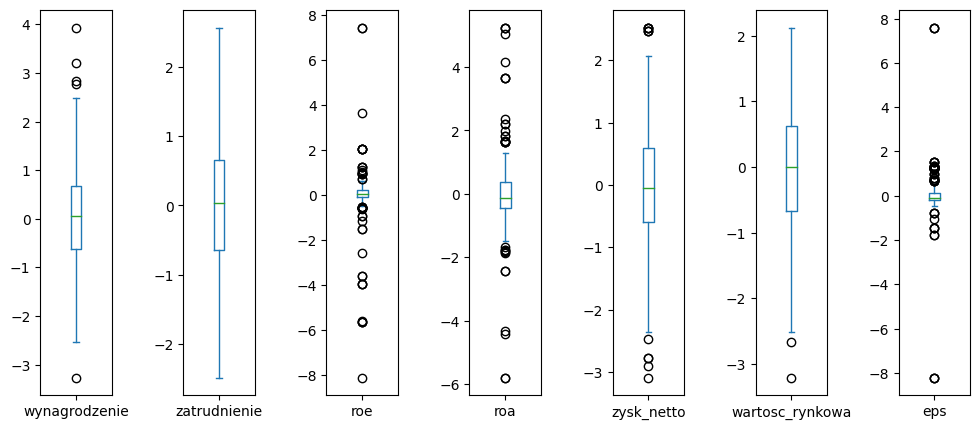

In [39]:
pt = PowerTransformer().set_output(transform='pandas')

df_pt = pt.fit_transform(df_complete.loc[:, numerical_vars])

df_pt.plot(kind='box', subplots=True, sharey=False, figsize=(12, 5))

# increase spacing between subplots
plt.subplots_adjust(wspace=1)
plt.show()

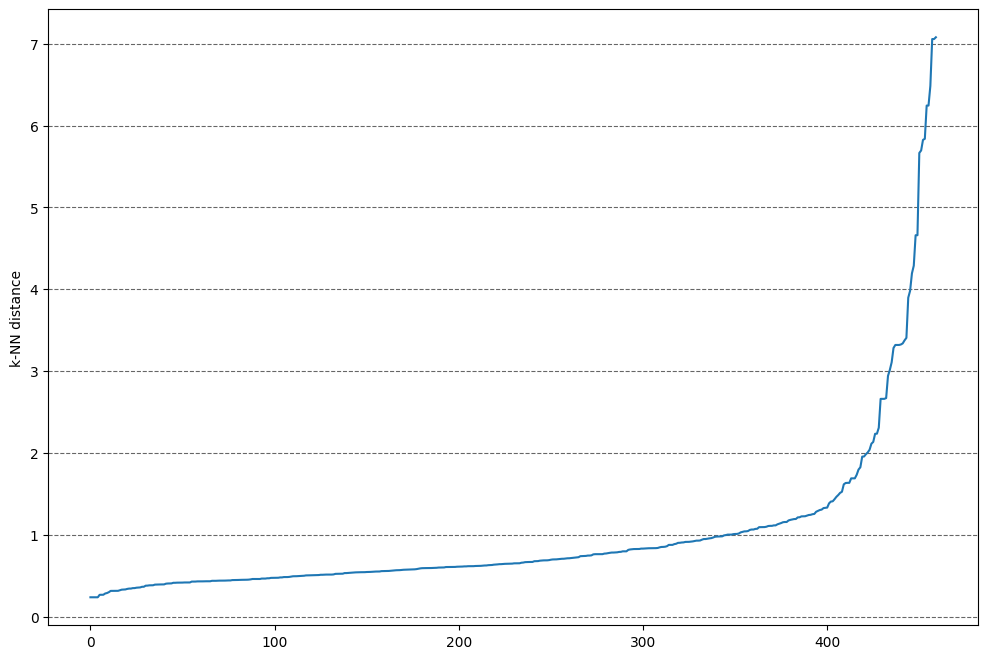

In [40]:
# searching for nearest neighbors
std_scaler = StandardScaler()
df_num_std = pd.DataFrame(std_scaler.fit_transform(df_pt),
                          columns=numerical_vars)

nn_ex = NearestNeighbors(n_neighbors=5)
neighbors_ex = nn_ex.fit(df_num_std)

distances_ex = neighbors_ex.kneighbors(df_num_std)[0][:, -1]

distances_sorted_ex = np.sort(distances_ex)

plt.plot(distances_sorted_ex)
plt.grid(axis='y', linestyle='--', color='black', alpha=0.6)
plt.ylabel('k-NN distance')
plt.show()

Graph shows a plot of the k nearest neighbours (kNN distance). The horizontal axis shows the numbers of observations, while the vertical axis shows the distances to the k nearest neighbours. This graph is used to analyse data density and identification of potential outliers. On its basis it was decided to set epsilon at 2,7.

Explained variance ratio by two components: 63.10%
Percentage of outliers: 5.65%


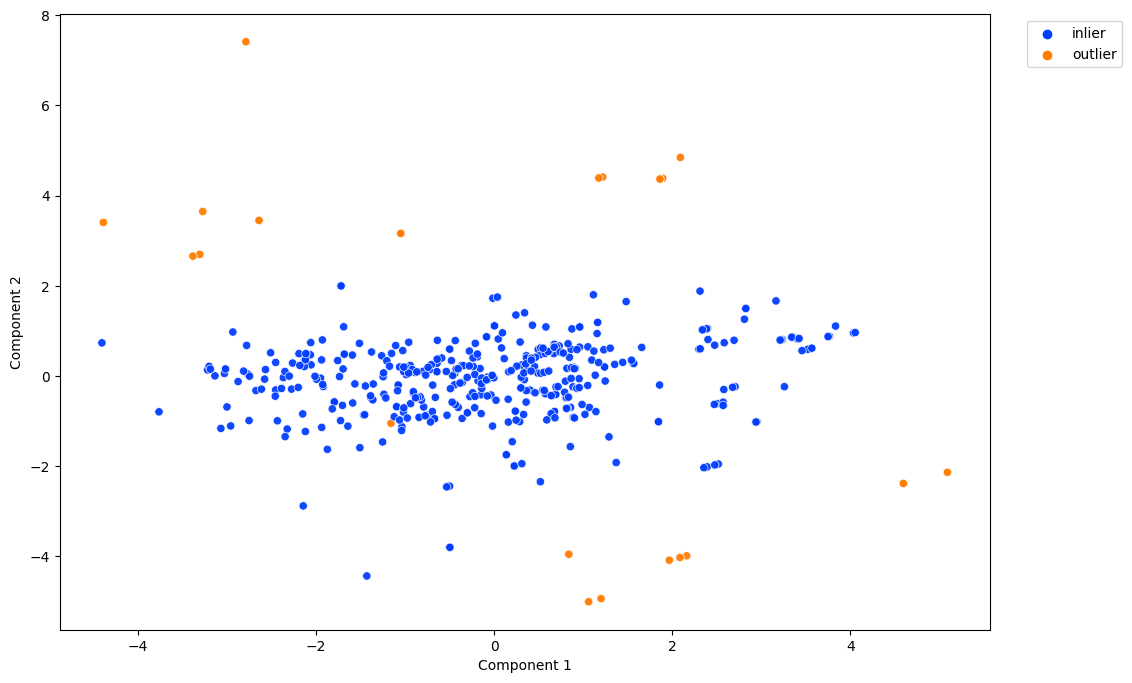

In [41]:
dbscan_ex = DBSCAN(eps=2.7)
dbscan_ex.fit(df_num_std)

labels_ex = dbscan_ex.labels_
df_num_std['cluster'] = labels_ex

ex_out_db = len(df_num_std[df_num_std['cluster'] == -1])

df_num_std['cluster'] = df_num_std['cluster'].apply(lambda x: 'outlier'
                                                    if x == -1 else 'inlier')

pca = PCA()
results_pca = pca.fit_transform(df_num_std.iloc[:, :-1])

components = pd.DataFrame(
    results_pca,
    columns=[f'Component {i}' for i in range(1, results_pca.shape[1] + 1)])
components['cluster'] = df_num_std['cluster']

explained_var_cumsum = np.cumsum(pca.explained_variance_ratio_)

print(
    f'Explained variance ratio by two components: {explained_var_cumsum[1]*100:.2f}%'
)
print(
    f"Percentage of outliers: {len(df_num_std[df_num_std['cluster'] == 'outlier']) / len(df_num_std)*100:.2f}%"
)

sns.scatterplot(x='Component 1',
                y='Component 2',
                data=components,
                alpha=0.95,
                hue='cluster',
                palette='bright')

plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

Principal Component Analysis was used to visualise outlier observations (PCA Principal Component Analysis) and a two-dimensional scatter plot was created. For this analysis, the first two principal components explain 63,19% of the variance, which is not that much, however scatter plot shows that most points further away from the cluster were detected.

In [42]:
df_complete['cluster'] = labels_ex
df_complete['cluster'] = df_complete['cluster'].apply(lambda x: 'outlier'
                                                      if x == -1 else 'inlier')
df_complete = df_complete[df_complete['cluster'] == 'inlier']
df_complete.drop(columns='cluster', inplace=True)
len(df_complete)

434

## Modelling

### Testing parameters of chosen models

Two binary variables were eliminated (_skarb_panstwa_TAK_ and *plec_M*) - without them MAE and RMSE values are lower on average plus both variables were imbalanced, which in small dataset is a problem.

In [43]:
cols_to_drop = ['skarb_panstwa_TAK', 'plec_M']

X = df_complete.drop(['wynagrodzenie', *cols_to_drop], axis=1)

y = df_complete.loc[:, 'wynagrodzenie']

To select the best regression model it was decided to compare a set of regression models effective in predicting continuous variables, where exogenous variables include categorical variables.

Due to the strong right-skewness of the distribution of the endogenous variable, it was decided
to use the Yeo Johnson transformation, which modifies the values of the variable so that its
distribution is close to a normal one. This ensures that there is less risk that predictions of salaries will be negative, which would conflict with logic.

In [44]:
def objective(trial):

    regressor_name = trial.suggest_categorical('regressor_name',
                                               ['cat', 'xgb', 'random_forest'])

    general_param = {
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
    }

    if regressor_name == 'cat':

        param = {
            "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
            "bagging_temperature": trial.suggest_int("bagging_temperature", 0,
                                                     10),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "random_strength": trial.suggest_int("random_strength", 0, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0, log=True),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
            'verbose': False
        }
        model = CatBoostRegressor(**param, **general_param)

    elif regressor_name == 'random_forest':

        param = {
            "min_samples_split":
            trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf":
            trial.suggest_int("min_samples_leaf", 2, 10),
            "max_features":
            trial.suggest_float("max_features", 0.1, 1),
            "min_impurity_decrease":
            trial.suggest_float("min_impurity_decrease", 0, 0.5),
            "max_leaf_nodes":
            trial.suggest_int("max_leaf_nodes", 2, 50),
            'verbose':
            False
        }

        model = RandomForestRegressor(**param, **general_param)

    else:

        param = {
            "alpha":
            trial.suggest_float("reg_alpha", 0.01, 0.5, log=True),
            "min_child_weight":
            trial.suggest_int("min_child_weight", 1, 5),
            "lambda":
            trial.suggest_float("reg_lambda", 0.01, 0.5, log=True),
            "gamma":
            trial.suggest_float("gamma", 0.01, 1.0, log=True),
            "colsample_bytree":
            trial.suggest_float("colsample_bytree", 0.5, 1, log=True),
            "colsample_bylevel":
            trial.suggest_float("colsample_bylevel", 0.5, 1, log=True),
            "colsample_bynode":
            trial.suggest_float("colsample_bynode", 0.5, 1, log=True),
            "subsample":
            trial.suggest_float("subsample", 0.5, 1.0, log=True),
            'learning_rate':
            trial.suggest_float("learning_rate", 0.01, 0.2),
            'early_stopping_rounds':
            10,
        }

        model = xgb.XGBRegressor(**param, **general_param)

    errors = []

    for seed in range(5):

        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=seed)

        pt = PowerTransformer(standardize=False)

        y_train = pt.fit_transform(y_train.values.reshape(-1, 1))[:, 0]
        y_test = pt.transform(y_test.values.reshape(-1, 1))[:, 0]

        if regressor_name == 'xgb':

            model.fit(X_train,
                      y_train,
                      eval_set=[(X_test, y_test)],
                      verbose=False)

        else:

            model.fit(X_train, y_train)

        preds = model.predict(X_test)
        error = mean_absolute_error(
            pt.inverse_transform(y_test.reshape(-1, 1))[:, 0],
            pt.inverse_transform(preds.reshape(-1, 1))[:, 0])
        errors.append(error)

    return np.mean(errors)

In order to find the optimal predictive model (with optimal hyperparameters), an analysis was carried out in which the mean absolute error (**MAE**) was minimised. **MAE** is one of the most popular indicators of model evaluation, which measures the average value of the absolute value of the difference between the actual and predicted values. In addition **MAE** is robust to outlier observations. The lower the MAE value, the better the quality of the model's prediction. Five splits were performed for each trial to prevent the overfitting problem.

In [ ]:
st = optuna.create_study(direction='minimize', storage=None)
st.optimize(objective, n_trials=1000, show_progress_bar=True, n_jobs=-1)

After 1000 iterations, the best model proved to be **XGBRegressor**.

In [46]:
best_params = st.best_params
best_error = st.best_value
print('Best params values:', best_params)
print('Lowest error (MAE):', best_error)

Best params values: {'regressor_name': 'xgb', 'max_depth': 5, 'n_estimators': 128, 'reg_alpha': 0.059592177035635664, 'min_child_weight': 5, 'reg_lambda': 0.11339420934038015, 'gamma': 0.9900512492677047, 'colsample_bytree': 0.9775531297550963, 'colsample_bylevel': 0.722002617957025, 'colsample_bynode': 0.6294195454095464, 'subsample': 0.7456448481128436, 'learning_rate': 0.162097433707379}
Lowest error (MAE): 178596.374558908


In [47]:
with open('params.pickle', 'wb') as f:
    pickle.dump(best_params, f)

In [48]:
with open('params.pickle', 'rb') as f:
    best_params = pickle.load(f)
print(best_params)

{'regressor_name': 'xgb', 'max_depth': 5, 'n_estimators': 128, 'reg_alpha': 0.059592177035635664, 'min_child_weight': 5, 'reg_lambda': 0.11339420934038015, 'gamma': 0.9900512492677047, 'colsample_bytree': 0.9775531297550963, 'colsample_bylevel': 0.722002617957025, 'colsample_bynode': 0.6294195454095464, 'subsample': 0.7456448481128436, 'learning_rate': 0.162097433707379}


In [49]:
del best_params['regressor_name']

### Predicting values

In [50]:
model_xgb = xgb.XGBRegressor(**best_params, eval_metric='mae')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pt = PowerTransformer(standardize=False)
y_train = pt.fit_transform(y_train.values.reshape(-1, 1))[:, 0]
y_test = pt.transform(y_test.values.reshape(-1, 1))[:, 0]

In [52]:
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.722002617957025,
             colsample_bynode=0.6294195454095464,
             colsample_bytree=0.9775531297550963, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=0.9900512492677047, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.162097433707379, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=128, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In order to assess the importance of individual variables in the predictive model,
forecasting was carried out on a validation dataset that accounted for 20% of the total dataset.This process involved applying the trained model to the validation dataset and predicting target values for the test samples. Then **Feature Importance** was shown, which made it possible to identify the
variables that contributed most to the predictions.

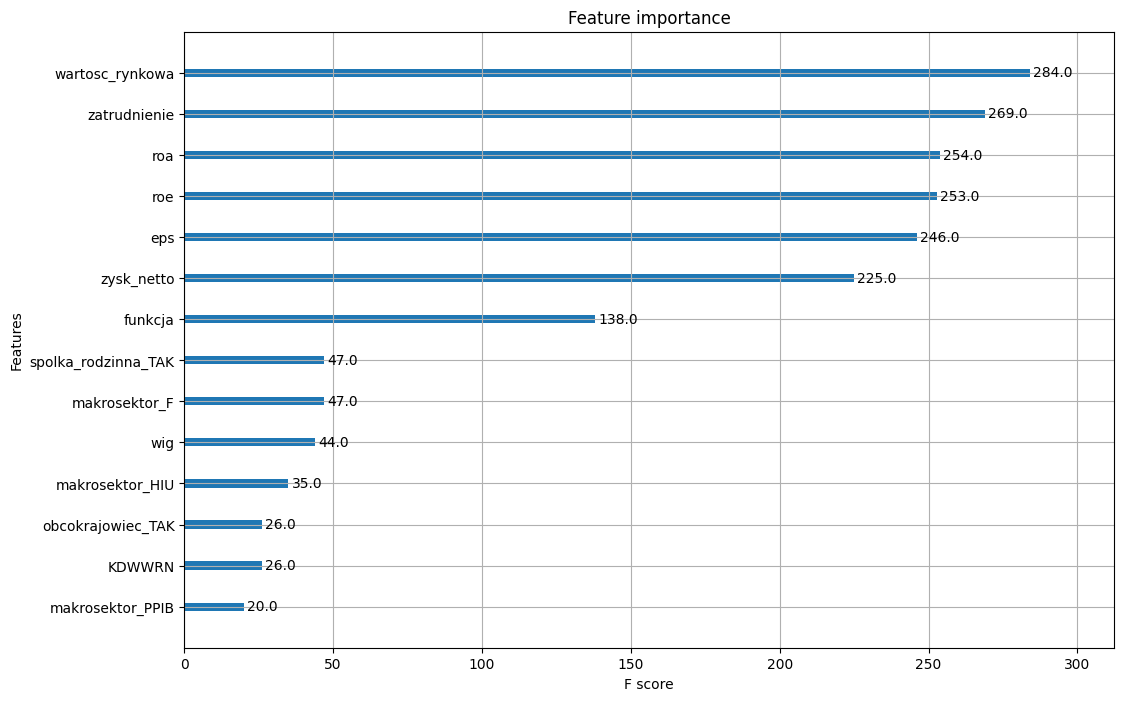

In [53]:
xgb.plot_importance(model_xgb)
plt.rcParams['figure.figsize'] = [12, 5]
plt.show()

In [54]:
pt = PowerTransformer(standardize=False)
model_xgb.fit(X, pt.fit_transform(y.values.reshape(-1, 1))[:, 0])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.722002617957025,
             colsample_bynode=0.6294195454095464,
             colsample_bytree=0.9775531297550963, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=0.9900512492677047, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.162097433707379, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=128, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [55]:
y_pred_xgb = model_xgb.predict(
    pred_df_complete.drop(columns=['wynagrodzenie', *cols_to_drop]))

In [56]:
y_pred_xgb = pt.inverse_transform(y_pred_xgb.reshape(-1, 1))[:, 0]

The _describe_ function was used to check basic statistics of the prediction data - main focus was on minimum values (verification that there are no negative values).

In [57]:
describe(y_pred_xgb)

DescribeResult(nobs=120, minmax=(32838.395, 2434128.2), mean=568156.6, variance=171258190564.0336, skewness=1.3747280349531803, kurtosis=2.9358887715487167)

Once the parameter optimisation process and variable validity analysis had been completed,
the XGBRegressor model was trained on the full set of available training data. Then, using this trained model, forecasting was performed on the set of test set. The results of the forecasts were compiled in an Excel file 'data_complete.xlsx' in the **Data** folder.

In [58]:
wb = load_workbook(filename='data/data.xlsx')

wb.worksheets

[<Worksheet "Zbiór uczący">, <Worksheet "Zbiór testowy">]

In [59]:
ws = wb.worksheets[1]

for row, value in enumerate(
        y_pred_xgb,
        start=2):  # 2nd row in worksheet is the first one to impute values

    ws.cell(row=row, column=1).value = value

wb.save('Data/data_complete.xlsx')